In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier

In [5]:
df = pd.read_csv('loan_data_set.csv')
df.head().T

,0,1,2,3,4
Loan_ID,LP001002,LP001003,LP001005,LP001006,LP001008
Gender,Male,Male,Male,Male,Male
Married,No,Yes,Yes,Yes,No
Dependents,0,1,0,0,0
Education,Graduate,Graduate,Graduate,Not Graduate,Graduate
Self_Employed,No,No,Yes,No,No
ApplicantIncome,5849,4583,3000,2583,6000
CoapplicantIncome,0.0,1508.0,0.0,2358.0,0.0
LoanAmount,NaN,128.0,66.0,120.0,141.0
Loan_Amount_Term,360.0,360.0,360.0,360.0,360.0


In [6]:
feature_mappings = {
    "Gender": {"Male": 0, "Female": 1},
    "Married": {"No": 0, "Yes": 1},
    "Education": {"Not Graduate": 0, "Graduate": 1},
    "Self_Employed": {"No": 0, "Yes": 1},
    "Property_Area": {"Rural": 0, "Semiurban": 1, "Urban": 2},
    "Loan_Status": {"N": 0, "Y": 1}
}
df = df.replace(feature_mappings)
df.drop_duplicates(inplace=True)
df.dropna(inplace=True)
df.shape, df.isnull().sum().sum()

/tmp/ipykernel_488076/1105577220.py:9: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace(feature_mappings)


((480, 13), np.int64(0))

In [7]:
df.columns

Index(['Loan_ID', 'Gender', 'Married', 'Dependents', 'Education',
       'Self_Employed', 'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount',
       'Loan_Amount_Term', 'Credit_History', 'Property_Area', 'Loan_Status'],
      dtype='object')

Train Accuracy: 0.84635
Test Accuracy: 0.80208


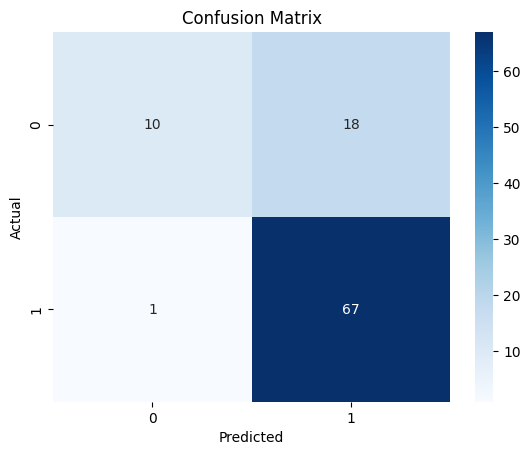

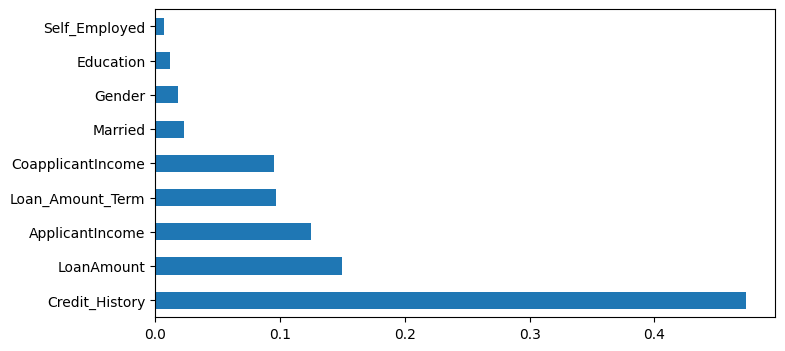

In [16]:
input_cols = ["Gender", "Married", "Education", "Self_Employed", "ApplicantIncome", \
              "CoapplicantIncome", "LoanAmount", "Loan_Amount_Term", "Credit_History"]

X_train, X_test, y_train, y_test = train_test_split(df[input_cols], df["Loan_Status"], \
                                                    test_size=0.2, random_state=42)
model = RandomForestClassifier(n_estimators = 10, max_depth = 5)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
accuracy_train = round(accuracy_score(y_train, model.predict(X_train)), 5)
accuracy_test = round(accuracy_score(y_test, y_pred), 5)
print(f"Train Accuracy: {accuracy_train}")
print(f"Test Accuracy: {accuracy_test}")
confusion_mat = confusion_matrix(y_test, y_pred)
sns.heatmap(confusion_mat, annot = True, fmt = "d", cmap = "Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()
feature_importance = pd.Series(model.feature_importances_, index = input_cols)\
                       .sort_values(ascending = False)
feature_importance.plot(kind = "barh", figsize=(8, 4))
plt.show()


In [17]:
import mlflow

mlflow.set_experiment("Loan_Prediction")

2025/03/08 12:54:41 INFO mlflow.tracking.fluent: Experiment with name 'Loan_Prediction' does not exist. Creating a new experiment.


<Experiment: artifact_location='file:///home/tirthankar-mittra/MLOpsApp/mlflow/mlruns/476440359817215547', creation_time=1741438481688, experiment_id='476440359817215547', last_update_time=1741438481688, lifecycle_stage='active', name='Loan_Prediction', tags={}>

In [22]:
def mlflow_runs(n_est, n_depth, i):
    with mlflow.start_run(run_name=f"RF_{i}") as run:
        model = RandomForestClassifier(n_estimators = n_est, max_depth = n_depth)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        accuracy_train = round(accuracy_score(y_train, model.predict(X_train)), 5)
        accuracy_test = round(accuracy_score(y_test, y_pred), 5)
        # Parameters
        mlflow.log_param("n_estimators", n_est)
        mlflow.log_param("max_depth", n_depth)
        # Metrics 
        mlflow.log_metric("train_accuracy", accuracy_train)
        mlflow.log_metric("test_accuracy", accuracy_test)
        # Model
        mlflow.sklearn.log_model(model, "loan_predictor", \
                                 input_example = X_train.head())
        # Confusion Matrix
        confusion_mat = confusion_matrix(y_test, y_pred)
        sns.heatmap(confusion_mat, annot = True, fmt = "d", cmap = "Blues")
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title("Confusion Matrix")
        plt.savefig("confusion_matrix.png")
        mlflow.log_artifact("confusion_matrix.png")
        plt.show()
        # Feature Importance
        feature_importance = pd.Series(model.feature_importances_, index = input_cols)\
                            .sort_values(ascending = False)
        feature_importance.plot(kind = "barh", figsize=(8, 4))
        plt.savefig("feature_importance.png")
        mlflow.log_artifact("feature_importance.png")
        plt.show()
        # Data 
        mlflow.log_artifact("loan_data_set.csv")

/home/tirthankar-mittra/mlops/lib/python3.12/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/home/tirthankar-mittra/mlops/lib/python3.12/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data co

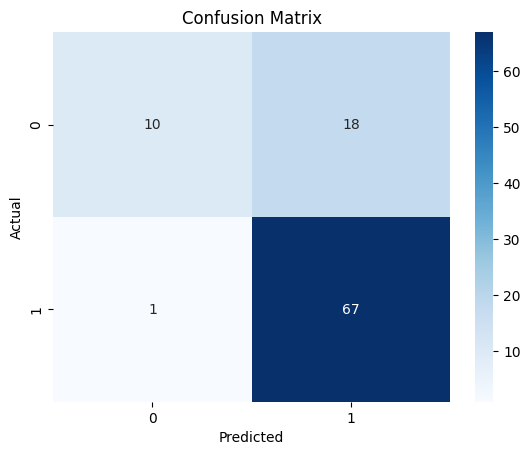

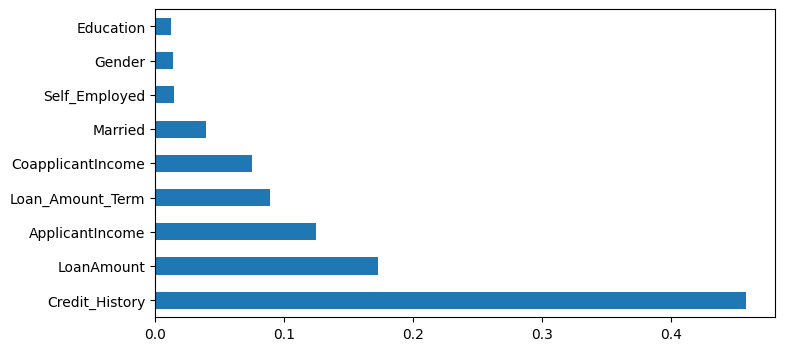

/home/tirthankar-mittra/mlops/lib/python3.12/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/home/tirthankar-mittra/mlops/lib/python3.12/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data co

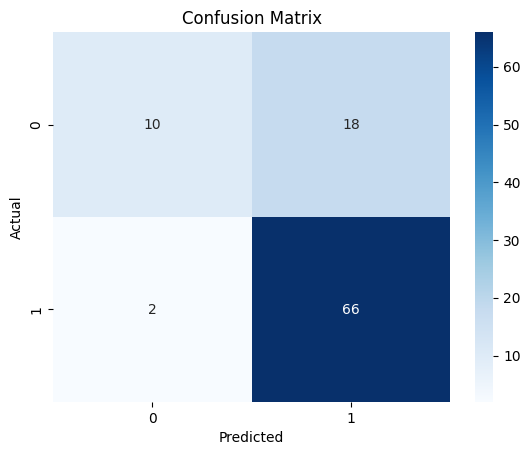

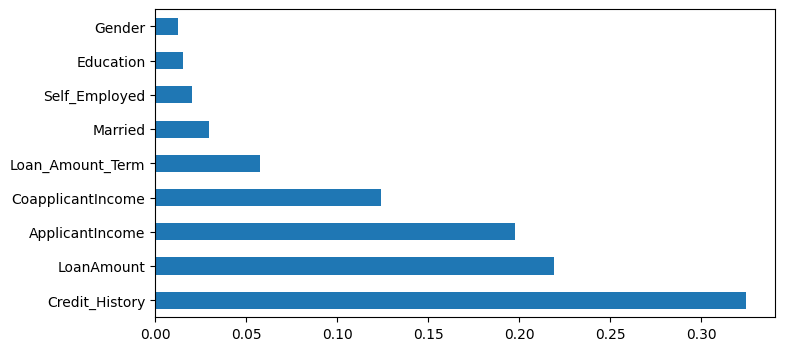

/home/tirthankar-mittra/mlops/lib/python3.12/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/home/tirthankar-mittra/mlops/lib/python3.12/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data co

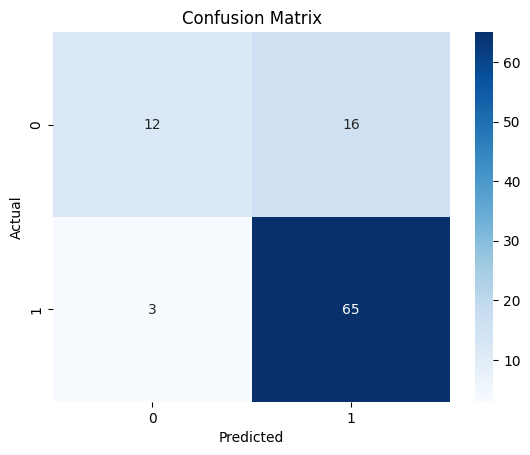

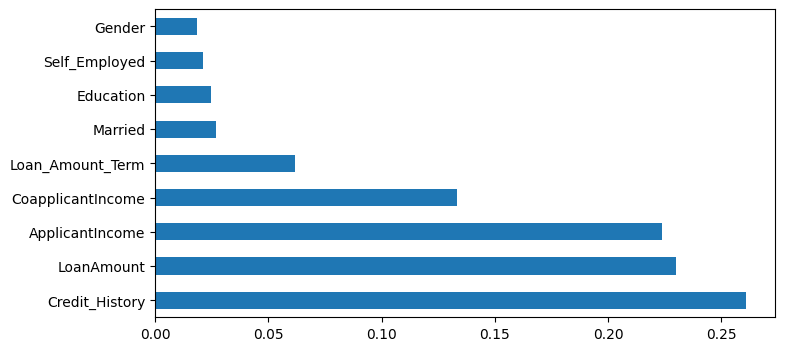

/home/tirthankar-mittra/mlops/lib/python3.12/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/home/tirthankar-mittra/mlops/lib/python3.12/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data co

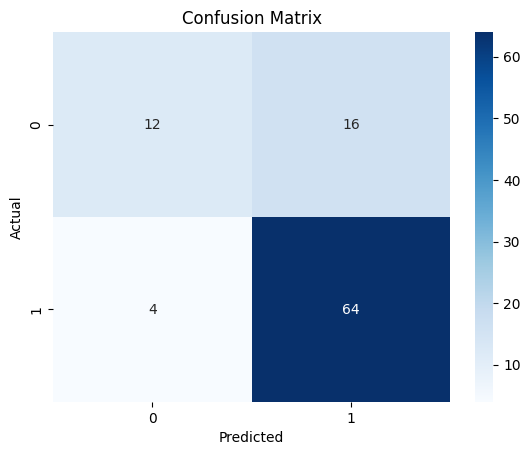

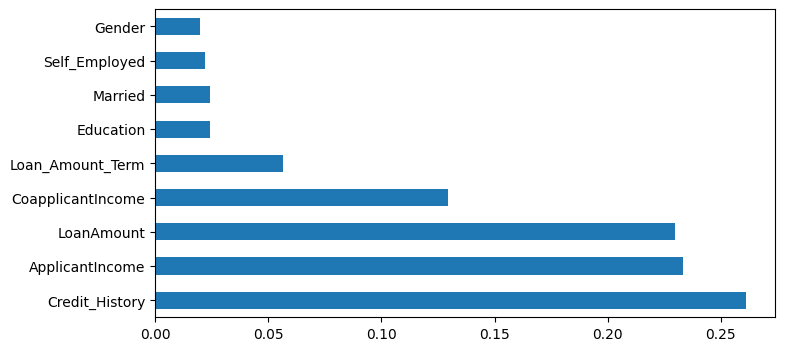

In [23]:
mlflow_runs(10, 5, 1)
mlflow_runs(20, 10, 2)
mlflow_runs(30, 15, 3)
mlflow_runs(40, 20, 4)